# The Big Project begins!!

## The Product Pricer

A model that can estimate how much something costs, from its description.

## Data Curation Part 1

Today we'll begin our scrubbing and curating our dataset by focusing on a subset of the data: Home Appliances.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [9]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [10]:
# imports

import os
# from dotenv imp/ort load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [ ]:
# environment

# load_dotenv()
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
# os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
# os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [5]:
# Log in to HuggingFace


from google.colab import userdata
hf_token = userdata.get('HF-SKC')
login(hf_token, add_to_git_credential=True)

In [6]:
# One more import - the Item class
# If you get an error that you need to agree to Meta's terms when you run this, then follow the link it provides you and follow their instructions
# You should get approved by Meta within minutes
# Any problems - message me or email me!
# With thanks to student Dr John S. for pointing out that this import needs to come after signing in to HF

from typing import Optional
from transformers import AutoTokenizer
import re

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
MIN_TOKENS = 150
MAX_TOKENS = 160
MIN_CHARS = 300
CEILING_CHARS = MAX_TOKENS * 7

class Item:
    """
    An Item is a cleaned, curated datapoint of a Product with a Price
    """

    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
    PREFIX = "Price is $"
    QUESTION = "How much does this cost to the nearest dollar?"
    REMOVALS = ['"Batteries Included?": "No"', '"Batteries Included?": "Yes"', '"Batteries Required?": "No"', '"Batteries Required?": "Yes"', "By Manufacturer", "Item", "Date First", "Package", ":", "Number of", "Best Sellers", "Number", "Product "]

    title: str
    price: float
    category: str
    token_count: int = 0
    details: Optional[str]
    prompt: Optional[str] = None
    include = False

    def __init__(self, data, price):
        self.title = data['title']
        self.price = price
        self.parse(data)

    def scrub_details(self):
        """
        Clean up the details string by removing common text that doesn't add value
        """
        details = self.details
        for remove in self.REMOVALS:
            details = details.replace(remove, "")
        return details

    def scrub(self, stuff):
        """
        Clean up the provided text by removing unnecessary characters and whitespace
        Also remove words that are 7+ chars and contain numbers, as these are likely irrelevant product numbers
        """
        stuff = re.sub(r'[:\[\]"{}【】\s]+', ' ', stuff).strip()
        stuff = stuff.replace(" ,", ",").replace(",,,",",").replace(",,",",")
        words = stuff.split(' ')
        select = [word for word in words if len(word)<7 or not any(char.isdigit() for char in word)]
        return " ".join(select)

    def parse(self, data):
        """
        Parse this datapoint and if it fits within the allowed Token range,
        then set include to True
        """
        contents = '\n'.join(data['description'])
        if contents:
            contents += '\n'
        features = '\n'.join(data['features'])
        if features:
            contents += features + '\n'
        self.details = data['details']
        if self.details:
            contents += self.scrub_details() + '\n'
        if len(contents) > MIN_CHARS:
            contents = contents[:CEILING_CHARS]
            text = f"{self.scrub(self.title)}\n{self.scrub(contents)}"
            tokens = self.tokenizer.encode(text, add_special_tokens=False)
            if len(tokens) > MIN_TOKENS:
                tokens = tokens[:MAX_TOKENS]
                text = self.tokenizer.decode(tokens)
                self.make_prompt(text)
                self.include = True

    def make_prompt(self, text):
        """
        Set the prompt instance variable to be a prompt appropriate for training
        """
        self.prompt = f"{self.QUESTION}\n\n{text}\n\n"
        self.prompt += f"{self.PREFIX}{str(round(self.price))}.00"
        self.token_count = len(self.tokenizer.encode(self.prompt, add_special_tokens=False))

    def test_prompt(self):
        """
        Return a prompt suitable for testing, with the actual price removed
        """
        return self.prompt.split(self.PREFIX)[0] + self.PREFIX

    def __repr__(self):
        """
        Return a String version of this Item
        """
        return f"<{self.title} = ${self.price}>"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Meta-Llama-3.1-8B.
403 Client Error. (Request ID: Root=1-674c9b0b-7d12642a755e70a1468282f5;760e456e-ac40-445b-b0d9-e7e2d9bdeb9a)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3.1-8B/resolve/main/config.json.
Access to model meta-llama/Llama-3.1-8B is restricted and you are not in the authorized list. Visit https://huggingface.co/meta-llama/Llama-3.1-8B to ask for access.

In [7]:
%matplotlib inline

In [11]:
# Load in our dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

README.md:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

meta_Appliances.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [12]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [16]:
# Investigate a particular datapoint
import json
datapoint = dataset[2]
print(json.dumps(datapoint))

{"main_category": "Tools & Home Improvement", "title": "Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504", "average_rating": 3.5, "rating_number": 18, "features": [], "description": ["Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504."], "price": "None", "images": {"hi_res": ["https://m.media-amazon.com/images/I/51TIpnkrEpL._AC_SL1500_.jpg"], "large": ["https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_.jpg"], "thumb": ["https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_US75_.jpg"], "variant": ["MAIN"]}, "videos": {"title": [], "url": [], "user_id": []}, "store": "GE", "categories": ["Appliances", "Parts & Accessories"], "details": "{\"Manufacturer\": \"RPI\", \"Part Number\": \"WE1M333,\", \"Item Weight\": \"0.352 ounces\", \"Package Dimensions\": \"5.5 x 4.7 x 0.4 inches\", \"Item model number\": \"WE1M333,\", \"Is Discontinued By Manufacturer\": \"No\", \"Item Package Quantity\": \"1\", \"Batteries Included?\": \"No\", \

In [17]:
# Investigate

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [18]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [19]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

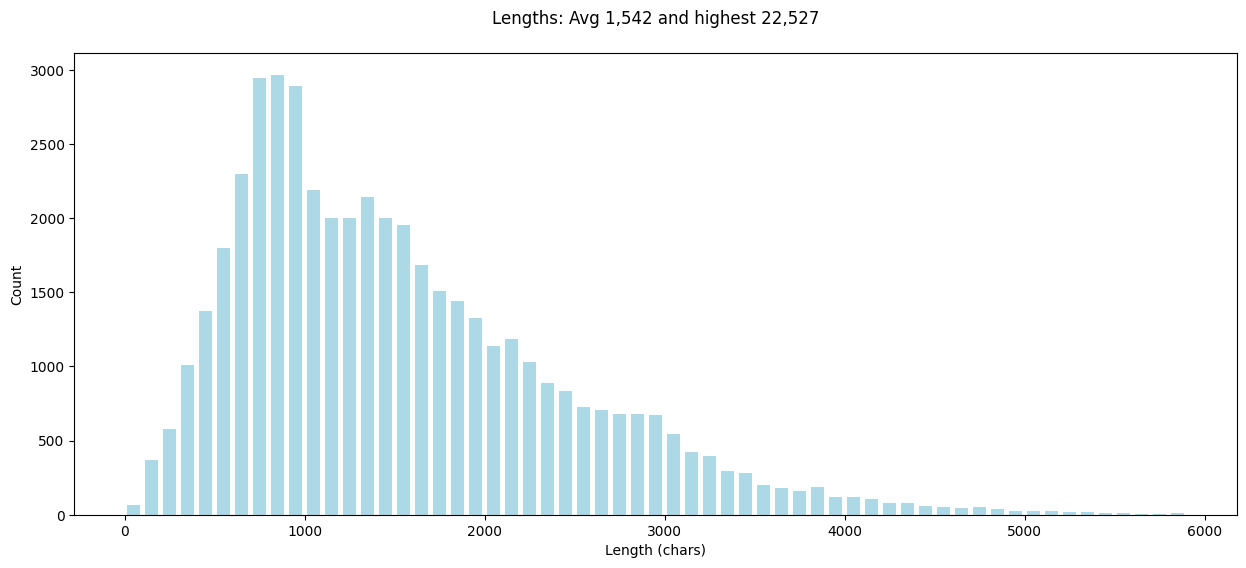

In [20]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

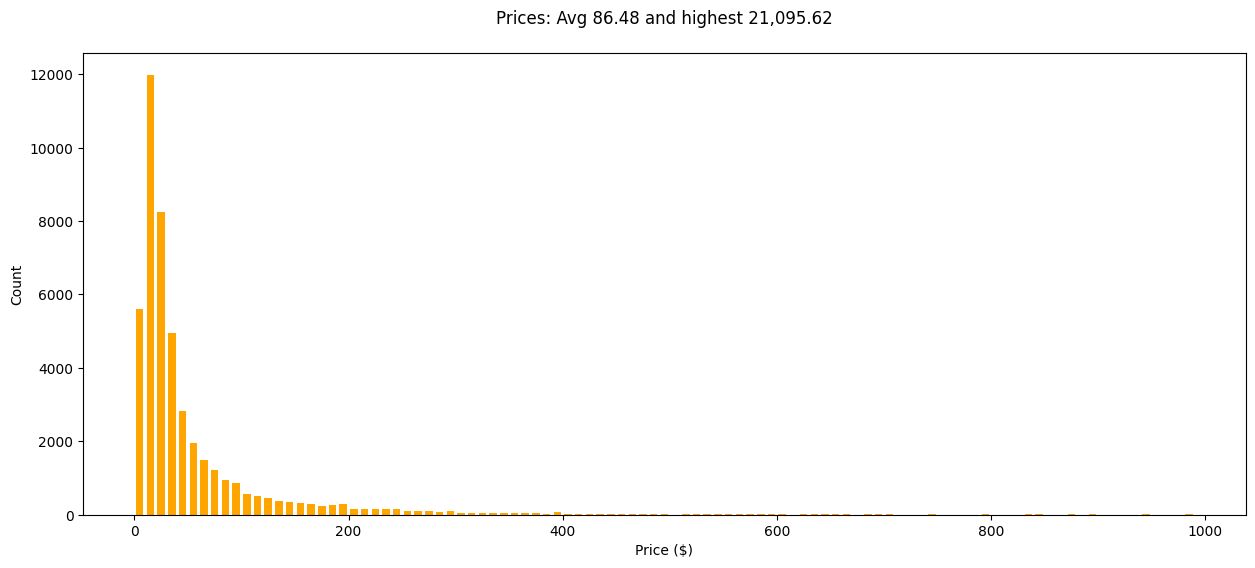

In [21]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [22]:
# So what is this item??

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


This is the closest I can find - looks like it's going at a bargain price!!

https://www.amazon.com/TurboChef-Electric-Countertop-Microwave-Convection/dp/B01D05U9NO/

## Now it's time to curate our dataset

We select items that cost between 1 and 999 USD

We will be create Item instances, which truncate the text to fit within 180 tokens using the right Tokenizer

And will create a prompt to be used during Training.

Items will be rejected if they don't have sufficient characters.

## But why 180 tokens??

A student asked me a great question - why are we truncating to 180 tokens? How did we determine that number? (Thank you Moataz A. for the excellent question).

The answer: this is an example of a "hyper-parameter". In other words, it's basically trial and error! We want a sufficiently large number of tokens so that we have enough useful information to gauge the price. But we also want to keep the number low so that we can train efficiently. You'll see this in action in Week 7.

I started with a number that seemed reasonable, and experimented with a few variations before settling on 180. If you have time, you should do the same! You might find that you can beat my results by finding a better balance. This kind of trial-and-error might sound a bit unsatisfactory, but it's a crucial part of the data science R&D process.

There's another interesting reason why we might favor a lower number of tokens in the training data. When we eventually get to use our model at inference time, we'll want to provide new products and have it estimate a price. And we'll be using short descriptions of products - like 1-2 sentences. For best performance, we should size our training data to be similar to the inputs we will provide at inference time.

## But I see in items.py it constrains inputs to 160 tokens?

Another great question from Moataz A.! The description of the products is limited to 160 tokens because we add some more text before and after the description to turn it into a prompt. That brings it to around 180 tokens in total.



In [ ]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

In [ ]:
# Look at the first item

items[1]

In [ ]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[100].prompt)

In [ ]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[100].test_prompt())

In [ ]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

In [ ]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

## Sidenote

If you like the variety of colors that matplotlib can use in its charts, you should bookmark this:

https://matplotlib.org/stable/gallery/color/named_colors.html

## Todos for you:

- Review the Item class and check you're comfortable with it
- Examine some Item objects, look at the training prompt with `item.prompt` and test prompt with `item.test_prompt()`
- Make some more histograms to better understand the data

## Next time we will combine with many other types of product

Like Electronics and Automotive. This will give us a massive dataset, and we can then be picky about choosing a subset that will be most suitable for training.